### Set up
- import packages
- load SAM2, CLIP

In [1]:
import numpy as np
import torch
import open_clip
from PIL import Image
import os
import json
import sys
# 添加父目录到 Python 路径
module_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from instruct_sam.counting import encode_image_as_base64, predict, count_gt, print_counts
from instruct_sam.visualize import visualize_prediction, show_sam_masks
from instruct_sam.matching import get_preprocess_rs5m, filter_boxes, match_boxes_and_counts
from instruct_sam.metrics import get_cat_map, convert_predictions_to_coco, evaluate_ap_f1
import cv2
from tqdm import tqdm
import time

#### Init VLM API

In [3]:
device = "cuda:0"
print(device)

# ViT-L/14 (DFN)
model_name = 'ViT-L-14' # ('ViT-L-14', 'dfn2b_s39b'),
# ckpt_path = '/home/zkcs/checkpoints/open-clip/vit-l/open_clip_pytorch_model.bin'
ckpt_path = '/home/zkcs/checkpoints/open-clip/dfn2b/open_clip_pytorch_model.bin'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=ckpt_path)
tokenizer = open_clip.get_tokenizer(model_name)
ckpt = torch.load(ckpt_path, map_location="cpu")
message = model.load_state_dict(ckpt)

# GeoRSCLIP
# ckpt_path = "/home/zkcs/checkpoints/open-clip/georsclip/RS5M_ViT-L-14.pt"
# # ckpt_path = "/home/zkcs/checkpoints/georsclip/ckpt/RS5M_ViT-L-14.pt"
# model, _, _ = open_clip.create_model_and_transforms("ViT-L/14", cache_dir='./')
# preprocess = get_preprocess_rs5m()
# checkpoint = torch.load(ckpt_path, map_location="cpu")
# tokenizer = open_clip.tokenize
# message = model.load_state_dict(checkpoint, strict=False)

print(message)
model = model.cuda(device).eval()
print(f"Total parameters: {sum(p.numel() for p in model.parameters())/1_000_000:.0f}M")

cuda:0


/tmp/ipykernel_1409368/777460992.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


<All keys matched successfully>
Total parameters: 428M


#### Init SAM2.1

In [4]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/home/zkcs/checkpoints/sam2/sam2_hiera_large.pt"
model_cfg = "//home/zkcs/zyj/sam2/sam2/configs/sam2/sam2_hiera_l.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2, pred_iou_thresh=0.7, points_per_side=32, crop_n_layers=0, box_nms_thresh=0.3, stability_score_thresh=0.7, min_mask_region_area=200)

### Instruct SAM

In [5]:
class InstructSAM:
    def __init__(self, annotations=None, img_dir=None, count_dir=None, rp_preds=None, lvis=False, device="cuda:0"):
        self.anns = annotations
        self.img_dir = img_dir
        self.count_dir = count_dir
        self.rp_preds = rp_preds
        self.lvis = lvis
        self.device = device
        if annotations is not None:
            self.categories = [cat['name'] for cat in annotations['categories']]
    
    def load_clip(self, model_name, ckpt_path=None):
        if model_name == 'clip':
            ckpt_path = '/home/zkcs/checkpoints/open-clip/vit-l/open_clip_pytorch_model.bin'
            self.clip_model, _, self.preprocess = open_clip.create_model_and_transforms(model_name, pretrained=ckpt_path)
            self.tokenizer = open_clip.get_tokenizer(model_name)
            ckpt = torch.load(ckpt_path, map_location="cpu")
            message = self.clip_model.load_state_dict(ckpt)
            
        elif model_name == 'georsclip':
            ckpt_path = "/home/zkcs/checkpoints/open-clip/georsclip/RS5M_ViT-L-14.pt"
            self.clip_model, _, _ = open_clip.create_model_and_transforms("ViT-L/14", cache_dir='./')
            self.preprocess = get_preprocess_rs5m()
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            self.tokenizer = open_clip.tokenize
            message = self.clip_model.load_state_dict(checkpoint, strict=False)
    
    def set_image(self, img_path):
        self.img_path = img_path
        self.img_name = os.path.basename(img_path)
        self.img_jpeg = Image.open(self.img_path)
        self.img_array = np.array(self.img_jpeg.convert("RGB"))
        if self.anns is not None:
            self.gt_counts = count_gt(self.anns, self.img_name, lvis=self.lvis)
        if self.lvis:
            self.img_id = int(self.img_name.split('.')[0])

    def load_rps_and_cnts(self, thr=0.0):
        if self.count_dir is not None:
            img_cnt_path = os.path.join(self.count_dir, self.img_name.replace('.jpg', '.json'))
            with open(img_cnt_path, 'r') as f:
                object_cnt = json.load(f)
            self.pred_counts = object_cnt
        
        if self.rp_preds is not None:
            pred = self.rp_preds[self.img_name]
            boxes, labels, scores = pred["bboxes"], pred["labels"], pred["scores"], 
            segmentations = pred["segmentations"] if "segmentations" in pred else None
            boxes, scores, labels, segmentations = filter_boxes(
                boxes, segmentations, scores, labels, thr)
            try:
                labels = [self.categories[int(label)] for label in labels]
            except:
                labels = ['RP'] * len(labels)
            self.bboxes = boxes
            self.segmentations = segmentations
            self.labels = labels
            self.scores = scores

    def count_objects(self, prompt, gpt_model="gpt-4o-2024-11-20", json_output=False):
        base64_image = encode_image_as_base64(self.img_path)
        completion = predict(prompt, base64_image, top_p=1, temperature=0.01,
                             model=gpt_model, json_output=json_output)
        response = completion.choices[0].message.content
        pred_counts = extract_counts_from_string(response)
        self.response = response
        self.pred_counts = pred_counts

    @staticmethod
    def fill_holes(mask):
        """
        Fill holes in a binary mask.
        
        Args:
            mask (np.ndarray): Binary mask as a uint8 numpy array (values 0 or 255).
            
        Returns:
            np.ndarray: Binary mask with holes filled.
            
        The algorithm uses a flood fill from the border to detect the background and then
        inverts the flood filled image to obtain the holes, which are then filled.
        """
        # Copy the mask to avoid modifying the original
        im_floodfill = mask.copy()
        
        # Create a mask that is 2 pixels larger than the original mask.
        h, w = mask.shape[:2]
        floodfill_mask = np.zeros((h + 2, w + 2), np.uint8)
        
        # Flood fill from the top-left corner (assumed to be background)
        cv2.floodFill(im_floodfill, floodfill_mask, (0, 0), 255)
        
        # Invert floodfilled image to get the holes
        im_floodfill_inv = cv2.bitwise_not(im_floodfill)
        
        # Combine the original mask with the holes filled (logical OR)
        filled_mask = mask | im_floodfill_inv
        return filled_mask

    @staticmethod
    def boolean_mask_to_coco_polygons(boolean_mask, epsilon=1.0):
        """
        Convert a boolean binary mask to COCO polygon segmentation format.
        
        Args:
            boolean_mask (np.ndarray): 2D boolean numpy array representing the mask 
                                    (True for foreground, False for background).
            epsilon (float): Approximation accuracy parameter for cv2.approxPolyDP.
                            Typical values range from 1.0 to 5.0 depending on image scale.
        
        Returns:
            list: A list of polygons, where each polygon is represented as a list of 
                [x1, y1, x2, y2, ..., xN, yN]. If the mask contains multiple connected 
                components, each component will be represented as a separate polygon 
                after hole filling.
        
        The function first fills any holes in the mask, then extracts contours for each 
        connected component using cv2.findContours with RETR_EXTERNAL. For each contour, 
        cv2.approxPolyDP is applied to simplify the curve, and if the resulting approximation 
        has at least three points, it is added to the list of polygons.
        """
        # Convert boolean mask to uint8 (0, 255)
        mask_uint8 = (boolean_mask.astype(np.uint8)) * 255

        # Fill holes in the mask
        mask_filled = InstructSAM.fill_holes(mask_uint8)
        
        # Find contours on the filled mask.
        # Use RETR_EXTERNAL since holes are filled and we only need outer boundaries.
        contours, _ = cv2.findContours(mask_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        polygons = []
        for contour in contours:
            # Filter out small contours based on area to remove noise.
            if cv2.contourArea(contour) < 10:
                continue

            # Simplify contour using polygonal approximation.
            approx = cv2.approxPolyDP(contour, epsilon, True)
            # Skip contour if it does not form a valid polygon (must have at least 3 points).
            if approx.shape[0] < 3:
                continue
            
            # Flatten the coordinates to [x1, y1, x2, y2, ..., xN, yN]
            polygon = approx.flatten().tolist()
            polygons.append(polygon)
        
        return polygons

    def segment_anything(self, mask_generator, max_masks=100, min_mask_region_area=200):
        masks = mask_generator.generate(self.img_array)
        
        # Filter masks by area
        masks = [mask for mask in masks if mask['area'] > min_mask_region_area]

        # Filter masks outside the image
        img_width, img_height = self.img_jpeg.size
        len_mask_all = len(masks)
        masks = [mask for mask in masks if mask['bbox'][0] < img_width and mask['bbox'][1] < img_height]
        if len(masks) < len_mask_all:
            print(f"Filtered {len_mask_all - len(masks)} masks outside the image")
        
        # Select max `max_masks` masks
        if len(masks) > max_masks:
            for mask in masks:
                mask['average_score'] = (
                    mask['predicted_iou'] + mask['stability_score']) / 2
            masks = sorted(
                masks, key=lambda x: x['average_score'], reverse=True)
            masks = masks[:max_masks]

        self.num_masks = len(masks)
        self.bboxes = [mask['bbox'] for mask in masks]
        self.segmentations = [self.boolean_mask_to_coco_polygons(mask['segmentation'], epsilon=1.0) for mask in masks]
        self.scores = [(mask['stability_score'] + mask['predicted_iou'])/2 for mask in masks]
        self.labels = ['region_preposal'] * self.num_masks
        self.masks = masks

    def show_masks(self):
        show_sam_masks(self.img_array, self.masks)

    @staticmethod
    def enhance_clip_prompt(cat_list, prefix='an image of', single=True):
        """
        Generates a list of prompts for each category in the input list.
        Args:
            cat_list (list of str): A list of category names,
            e.g., ['people', 'skis'].
        Returns:
            list of str: A list of prompts,
            e.g., ['an image of a person', 'an image of skis'].
        """
        vowels = 'aeiou'
        prompts = []
        
        for category in cat_list:
            article = 'an' if category[0].lower() in vowels else 'a'
            if single:
                prompts.append(f'{prefix} {article} {category}')
            else:
                prompts.append(f'{prefix} {category}')
        
        return prompts
    
    def calculate_vocab_text_features(self, clip_model, tokenizer):
        enhanced_prompt = self.enhance_clip_prompt(self.categories)
        TARGET_CATEGORY_tokens = tokenizer(enhanced_prompt).to(next(clip_model.parameters()).device)
        with torch.no_grad():
            TARGET_FEATURES = clip_model.encode_text(TARGET_CATEGORY_tokens)
            TARGET_FEATURES /= TARGET_FEATURES.norm(dim=-1, keepdim=True)
        self.vocab_features = TARGET_FEATURES
    
    def calculate_pred_text_features(self, clip_model, tokenizer, open_world=False):
        """calculate text features of predicted categories

        Args:
            clip_model (_type_): _description_
            open_world (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        # if self has vocab features, use it
        if not open_world:
            assert hasattr(self, 'vocab_features') == True, "Please calculate vocab features first"
            gpt_predicted_classes = [cls for cls, count in self.pred_counts.items() if count > 0]
            if not gpt_predicted_classes:
                print(f"No categories predicted for {self.img_name}")
                self.pred_text_features = None
                return None
            self.pred_text_features = torch.stack(
                [self.vocab_features[self.categories.index(cls)] for cls in gpt_predicted_classes]
            )        
            return self.pred_text_features
        else:
            # categories = self.pred_counts.keys()
            gpt_predicted_classes = [cls for cls, count in self.pred_counts.items() if count > 0]
            assert len(gpt_predicted_classes) > 0, "No categories predicted"
            cat_prompt = self.enhance_clip_prompt(gpt_predicted_classes)
            with torch.no_grad():
                text_memory = tokenizer(cat_prompt)
                text_features = clip_model.encode_text(text_memory.cuda(device))
                text_features /= text_features.norm(dim=-1, keepdim=True)
            self.pred_text_features = text_features
            return self.pred_text_features

    def match_boxes_and_labels(self,
                               clip_model, preprocess,
                               crop_scale=1.2, min_crop_width=0,
                               show_similarities=False):
        """
        Match predicted boxes with predicted counts
        
        Args:
            clip_model (torch.nn.Module): OpenCLIP model
            preprocess (torchvision.transforms): OpenCLIP preprocess
            crop_scale (float, optional): Crop scale. Defaults to 1.2.
            min_crop_width (int, optional): Minimum crop width. Defaults to 0.
            show_similarities (bool, optional): Show similarities. Defaults to False.
        
        Returns:
            list: Final boxes and labels (category names)
        """
        boxes_final, labels_final, segmentations_final, scores_final = match_boxes_and_counts(
            self.img_jpeg, self.bboxes, self.pred_counts, self.pred_text_features,
            clip_model, preprocess, self.segmentations,
            crop_scale=crop_scale,
            min_crop_width=min_crop_width,
            show_similarities=show_similarities)
        self.boxes_final = boxes_final
        self.labels_final = labels_final
        self.segmentations_final = segmentations_final
        self.scores_final = scores_final
        return boxes_final, labels_final, segmentations_final, scores_final

In [6]:
# img_dir = '/home/zkcs/datasets/nwpu/pos_img'
# ann_path = '/home/zkcs/datasets/nwpu/nwpu_coco.json'
# count_dir = './object_counts/nwpu/gpt-4o-2024-11-20'
# rp_path = './region_proposals/nwpu/sam2_pred_NWPU_VHR-10.json'
# img_name_list = os.listdir(img_dir)
# with open(ann_path, 'r') as f:
    # val_anns = json.load(f)
# with open(rp_path, 'r') as f:
    # rp_preds = json.load(f)

# pre_path = '/home/zkcs/datasets/xBD_raw/test/images/hurricane-florence_00000200_pre_disaster.png'
# post_path = '/home/zkcs/datasets/xBD_raw/test/images/hurricane-florence_00000200_post_disaster.png'
image_path = '/home/zkcs/zyj/reason_example/100.jpg'
instruct_sam = InstructSAM()

In [7]:
instruct_sam.set_image(image_path)
# instruct_sam.img_name
# visualize_gt(val_anns, instruct_sam.img_path, dpi=100, lvis=instruct_sam.lvis)

In [22]:
prompt = """
"Task": "Count the number of object that near recreational spaces that would be effective in hosting a highly interactive community sports gathering",
"Output format": "{ "name1": count1, "name2": count2, ... }"
"""
instruct_sam.count_objects(prompt, gpt_model="gpt-4o-2024-11-20", json_output=True)
print(instruct_sam.response)
# print_counts(instruct_sam.pred_counts, instruct_sam.gt_counts)
# print(instruct_sam.pred_counts)

AuthenticationError: Error code: 401 - {'error': {'message': '令牌 v3test（#37968）额度已用尽 (request id: 2025050915181611756011396989885)', 'type': 'v_api_error'}}

In [8]:
instruct_sam.pred_counts = {
    "capacitor": 14,
    "resistor": 12,
    "inductor": 2,
    "integrated_circuit": 1
}

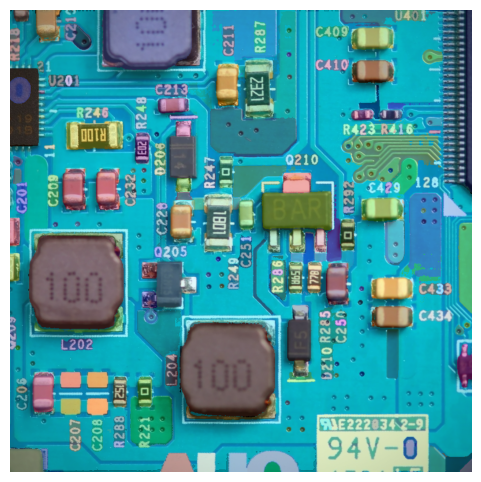

243

In [9]:
mask_generator = SAM2AutomaticMaskGenerator(sam2, pred_iou_thresh=0.6, stability_score_thresh=0.6,
                                            points_per_side=24, crop_n_layers=1, box_nms_thresh=0.3)
instruct_sam.segment_anything(mask_generator, max_masks=300, min_mask_region_area=10)
instruct_sam.show_masks()
instruct_sam.num_masks

In [10]:
instruct_sam.bboxes
instruct_sam.segmentations[0]   # polygan. COCO RLE 格式，无损压缩 SIOR
instruct_sam.pred_counts

{'capacitor': 14, 'resistor': 12, 'inductor': 2, 'integrated_circuit': 1}

color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.35121374 0.55535802 0.27732635]
color [0.3512137

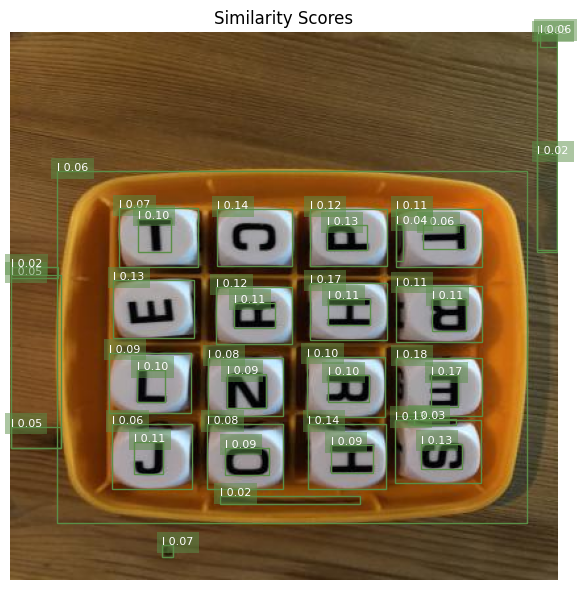

color [0.34107635 0.72942907 0.314659  ]
color [0.23906254 0.23705967 0.05423466]
color [0.23906254 0.23705967 0.05423466]
color [0.34107635 0.72942907 0.314659  ]
color [0.94022103 0.16414513 0.74571168]


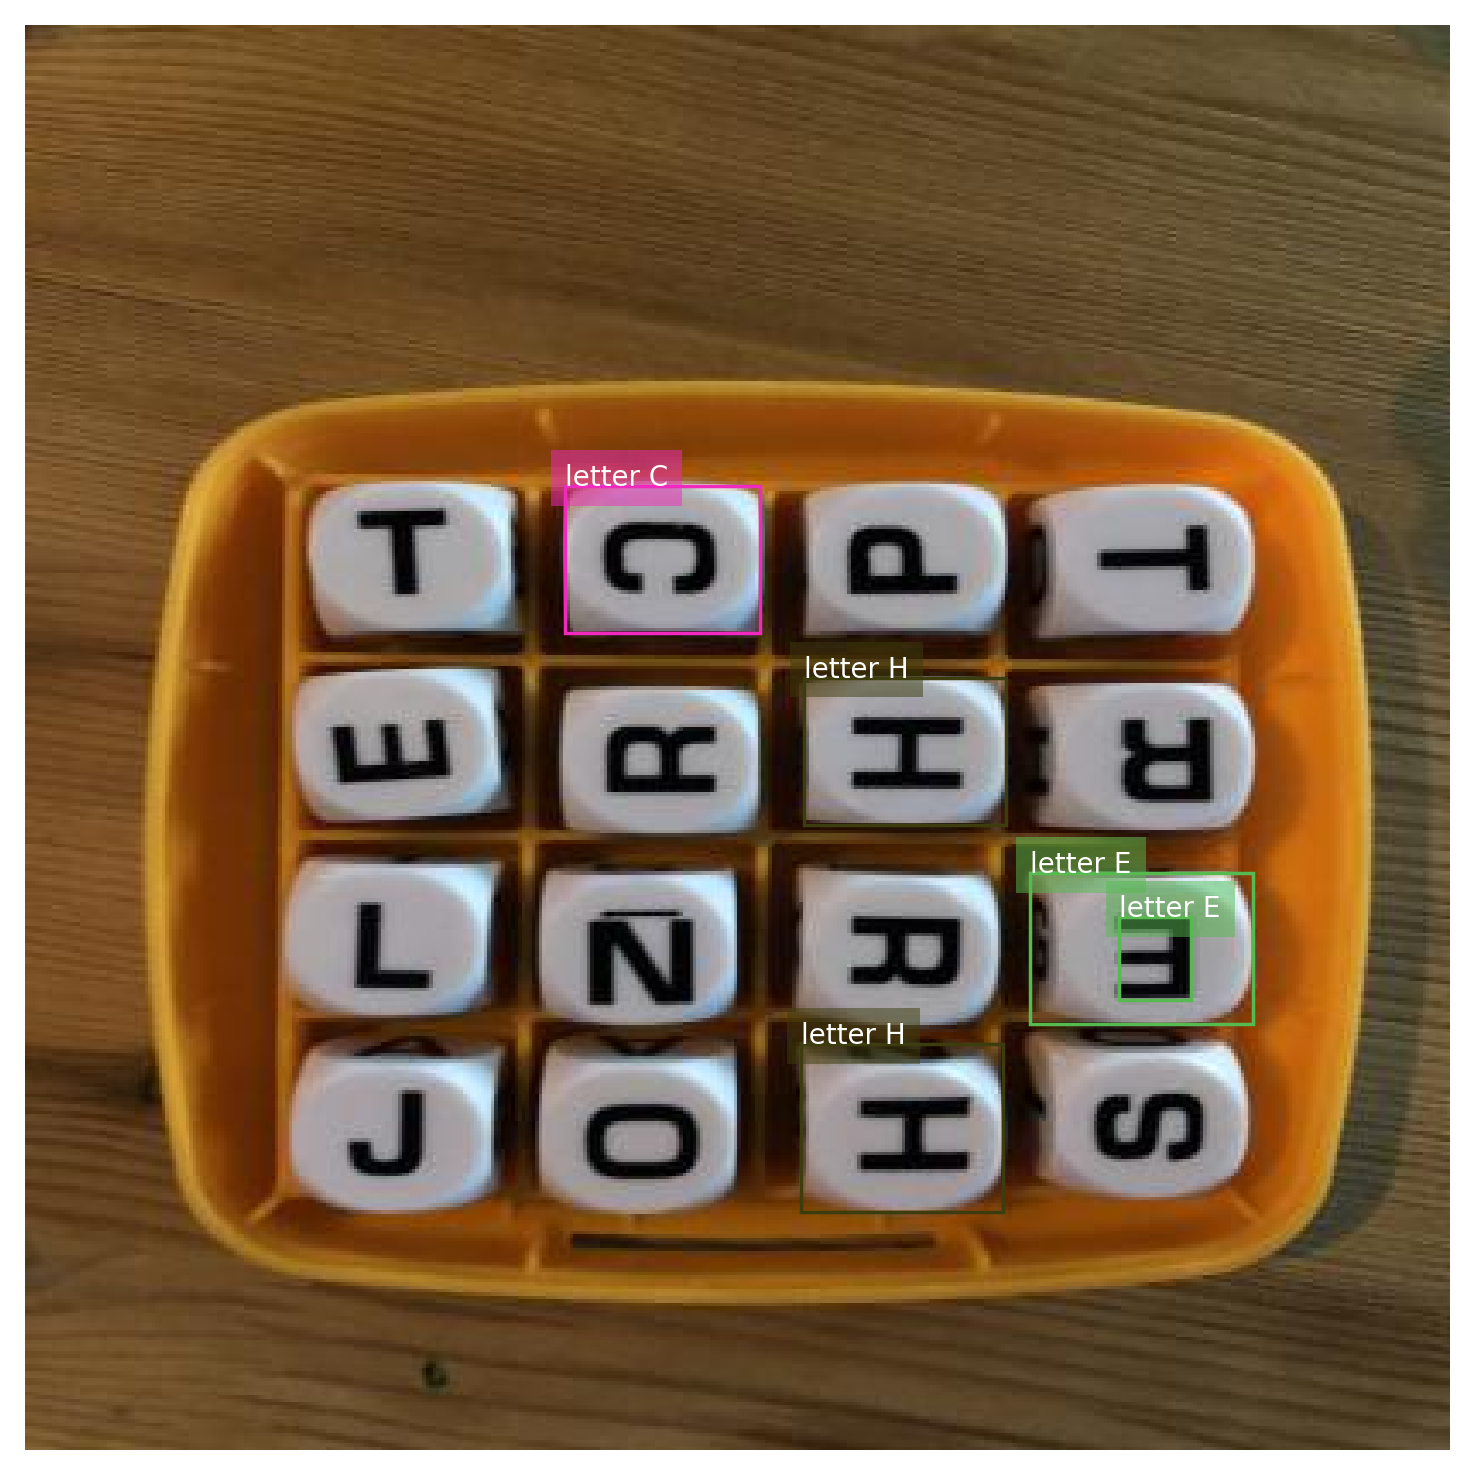

In [68]:
instruct_sam.set_image(image_path)
instruct_sam.calculate_pred_text_features(model, tokenizer, open_world=True)
instruct_sam.match_boxes_and_labels(model, preprocess, show_similarities=True, min_crop_width=0)
# print(instruct_sam.boxes_final)
# print(instruct_sam.labels_final)
visualize_prediction(instruct_sam.img_array, instruct_sam.boxes_final, instruct_sam.labels_final,instruct_sam. , dpi=250,
                    show_gt=False, title=None,save_path=image_path.replace('.jpg', '_instructsam.jpg'))
#save image 
box_final = instruct_sam.boxes_final
label_final = instruct_sam.labels_final
results = []
for box, label in zip(box_final, label_final):
    results.append({
        "bbox": box,
        "label": label,
        "score": 1.0,
        "image_id": 100

    })
save_json_path = image_path.replace('.jpg', '_instructsam.json')
with open(save_json_path, 'w') as f:
    json.dump(results, f)


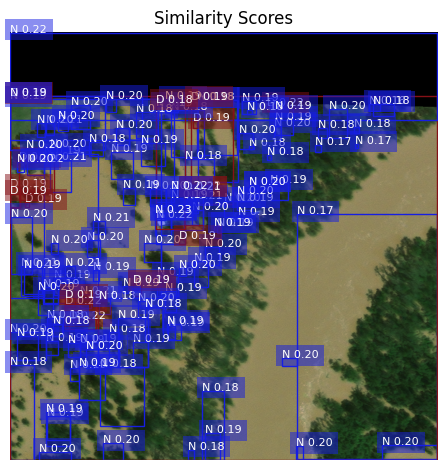

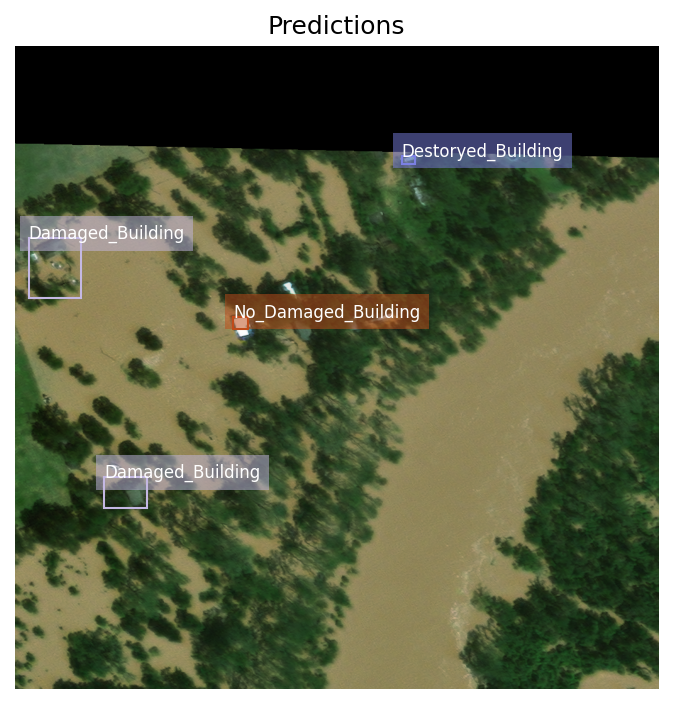

In [20]:
post_path = '/home/zkcs/datasets/xBD_raw/train/images/hurricane-harvey_00000224_post_disaster.png'

instruct_sam.set_image(post_path)
instruct_sam.pred_counts = {"Damaged_Building": 2, "No_Damaged_Building": 1, "Destoryed_Building": 1}
instruct_sam.calculate_pred_text_features(model, tokenizer, open_world=True)
instruct_sam.match_boxes_and_labels(model, preprocess, show_similarities=True, min_crop_width=0)
visualize_prediction(instruct_sam.img_array, instruct_sam.boxes_final, instruct_sam.labels_final, dpi=150,
                    show_gt=False, title='Predictions')


In [42]:
import json

# 从文件读取 JSON 数据
# /home/zkcs/datasets/xBD_raw/test/images/hurricane-florence_00000200_pre_disaster.png
file_path = "/home/zkcs/datasets/xBD_raw/test/labels/hurricane-florence_00000200_post_disaster.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# 统计 building 的数
no_damage = 0
major_damage = 0
minor_damage = 0
destroyed = 0
for feature in data["features"]["xy"]:  # 根据你的数据结构调整这里的键名
    if feature["properties"]["subtype"] == "no-damage":
        no_damage += 1
    if feature["properties"]["subtype"] == "major-damage":
        major_damage += 1
    if feature["properties"]["subtype"] == "minor-damage":
        major_damage += 1
    if feature["properties"]["subtype"] == "destroyed":
        major_damage += 1
        

# 输出结果
print(f"no-damage: {no_damage}")
print(f"minor-damage: {minor_damage}")
print(f"major-damage {major_damage}")
print(f"destroyed {destroyed}")
print(len(data["features"]["xy"]))

no-damage: 21
minor-damage: 0
major-damage 0
destroyed 0
21
